In [3]:
%load_ext autoreload
%autoreload 2

import fiona
import geopandas as gpd
from glob import glob
import laspy
import matplotlib.pyplot as plt
import numpy as np
import os
if os.getcwd()=="/Users/josesmac/Desktop/UA_Files_Joses/UA_PhD_Coursework_Assignments/2024_Spring/GEN_580/Project":
    os.chdir("../")
import pandas as pd
import pygmt
from utils import distance_along_profile_proj_crs,dip_to_slope
from scipy.spatial import cKDTree
import xarray as xr

fiona.drvsupport.supported_drivers['KML'] = 'rw'
np.random.seed(580)

### Basemap

In [29]:
region = [-113.59,-112.73,37.0,37.60]
dem_grid = pygmt.datasets.load_earth_relief("03s", region=region, registration="gridline")

znp_bound = gpd.read_file("Files/Cropped_Cable_Mtn_Profiles/Zion_Boundary/Zion.shp")
znp_bound = znp_bound.to_crs("EPSG:4327")

grdblend [NOTICE]: Remote data courtesy of GMT data server oceania [http://oceania.generic-mapping-tools.org]
grdblend [NOTICE]: Earth Relief at 3x3 arc seconds tiles provided by SRTMGL3 (land only) [NASA/USGS].
grdblend [NOTICE]:   -> Download 1x1 degree grid tile (earth_relief_03s_g): N37W114


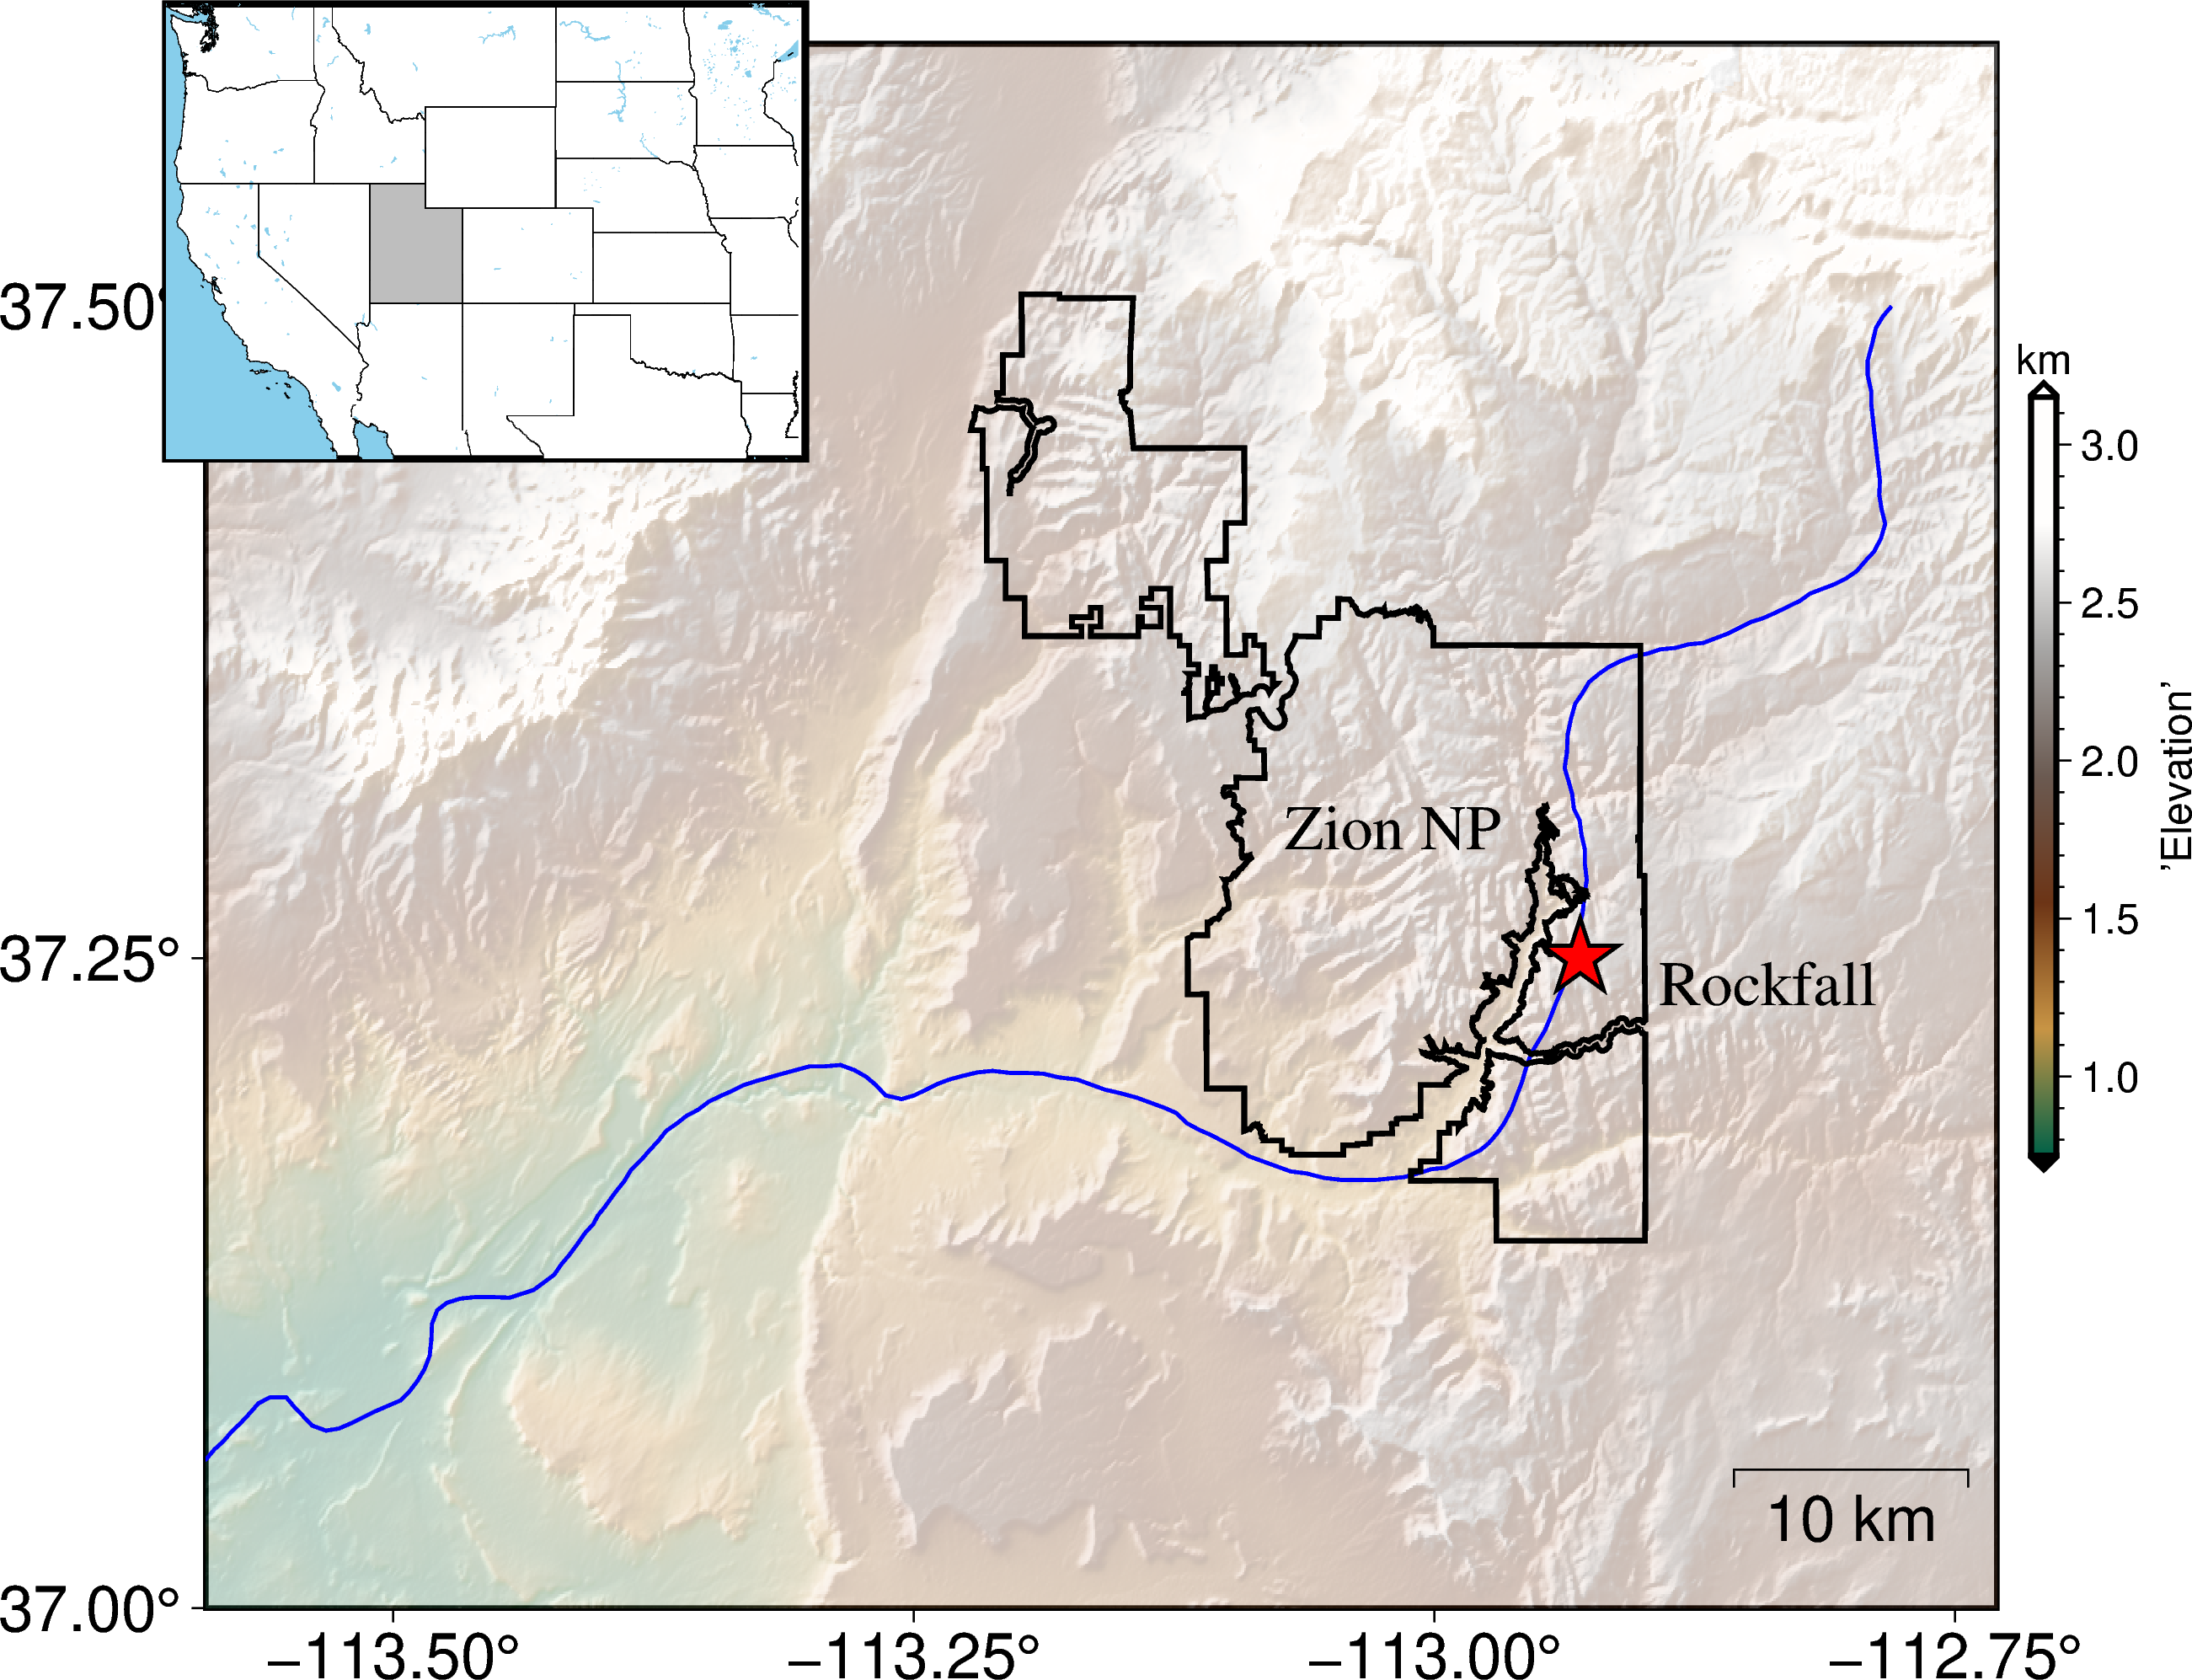

In [80]:
fig = pygmt.Figure()

pygmt.config(MAP_FRAME_TYPE="plain",FONT_ANNOT_PRIMARY="18p",FONT_LABEL="16p",FONT_TAG="16p",FORMAT_GEO_MAP="ddd.xx")

fig.basemap(region=region, projection="M18c",frame=["WSrt","a"])

# ------------------------ Plot high res DEM, make a color limit, plot the basemap ------------------------
pygmt.makecpt(cmap="geo",series="750/3300/400", continuous=True)
fig.grdimage(grid=dem_grid, shading=True, transparency=70, frame=None)
fig.coast(rivers="r/1p,blue",shorelines=True,map_scale="g-112.8/37.05+w10k+al+ukm",borders="2/0.5p,black")

# ------------------------------------ Plot the shapefiles ------------------------------------
fig.plot(region=region, data=znp_bound, pen="1.5p,black", label="Fault") # Zion National Park boundary
fig.plot(x=-112.93, y=37.25, style="a0.8c", pen="1p,black", fill="red")
fig.text(text=["Zion NP","Rockfall"],font="18p,Times-Roman,black",x=[-113.02, -112.84],y=[37.3, 37.24])

# # ------------------------------------ Inset Map ------------------------------------
with fig.inset(position="jTL+w2.53i/1.8i+o-0.4c", box="+gwhite+p2p"):
    fig.coast(region=[-125,-91,30,55],projection="M2.5i",borders="2/0.2,black",shorelines="1/0.2p,black",
              water="skyblue",dcw=["US.UT+ggrey+p0.2p","US.TX+gwhite+p0.2p","US.WY+gwhite+p0.2p"],resolution="h")

# ------------------------------------ Color Bar------------------------------------
pygmt.config(FONT_ANNOT_PRIMARY="12p",FONT_LABEL="12p")
fig.colorbar(frame=["x+l'Elevation'","y+lkm"],scale=0.001, position="jMR+o-0.6/0.5c+w3i/0.1i+e+m+v",)

fig.savefig("Figures/Zion_NP_Study_Area.png")
fig.show()

### Factor of Safety

In [4]:
print(np.sqrt((3200*0.006)/np.pi))
rba = (2.52**2)*3
rbp = rba/3200
k2c = 2.5
b = 31.91
a = np.sqrt((3200*rbp)/np.pi)#2.67
print(rba,rbp,a)
wt = 35.2
cohesion = (k2c * 2 * np.power(rbp,0.75)) / np.sqrt(np.pi*b)
shear_stress = wt / (np.pi*(b**2))
k2a = wt / (2*a*np.sqrt(np.pi*a))
fs = cohesion/shear_stress # k2c/k2a factor of safety using either option. Should have similar results
print(fs,cohesion,shear_stress,k2a)

2.472154892948413
19.0512 0.0059535000000000005 2.4625566599907165
0.9726839549516425 0.010703133301765727 0.011003711171834678 2.569557755994949


### Mode I Time dependent failure
Mode II and III are more complex <br>
Stress intensity factor $(K_1) = \frac {\sigma2W} {\sqrt{\pi a}}$ <br>
$\sigma$ = stress <br>
$W$ = block width <br>
$a$ = rock bridge width <br>

In [5]:
# wt = 0.0027
# a0 = 0.005
wt = 35.2
# Rock bridge width is a, so half width is a/2
a0 = 2.46/2
# Block width is W, so half width is W/2
W = 87/2
# Stress is the weight of the block (wt defined above)
k1c = 30.6      # Fracture toughness MPa sqrt(m)
A = 0.0067     # Rock failure rate (m/s)
n = 27         # timesteps
k1 = (wt*2*W)/(np.sqrt(np.pi*1)) # Stress intensity factor
# Critical stress (\sigma_{1c}) occurs when the mode 1 stress intensity factor equals fracture toughness
wtc = k1 * (1/k1c)#k1c/k1 # Mpa
print(f"This block requires  {wtc:.4f} MPa to fail")
charles_law = A * (wtc ** n)
# n/2 + 1
n2 = n/2+1
# time to failure in secs
ttf = (a0**n2) / (A * charles_law * n2)
ttf_yr = ttf / (60*60*24*365)

print(ttf_yr)

This block requires  56.4632 MPa to fail
4.938896931250855e-51


,idx,time (yr),a
0,0.000000,0.000000e+00,1.230000
1,0.038462,1.899576e-52,1.226677
2,0.076923,3.799151e-52,1.223229
3,0.115385,5.698727e-52,1.219644
4,0.153846,7.598303e-52,1.215911
5,0.192308,9.497879e-52,1.212016
6,0.230769,1.139745e-51,1.207944
7,0.269231,1.329703e-51,1.203679
8,0.307692,1.519661e-51,1.199199
9,0.346154,1.709618e-51,1.194481


(Text(0.5, 0, 'time (years)'), Text(0, 0.5, 'rock bridge length (m)'))

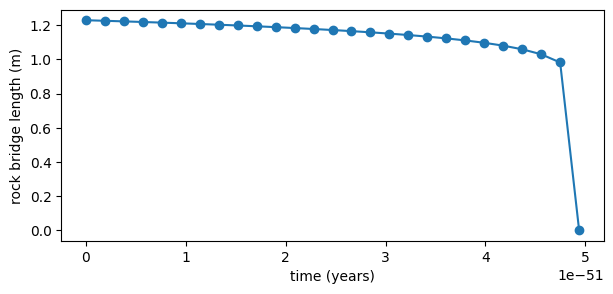

In [6]:
timesteps = np.linspace(0,1,n)
time_years = timesteps * ttf_yr
rock_bridge_rad_through_time = ((a0**n2) - (A*charles_law*n2*time_years*365*24*60*60))**(1/n2)

time_df = pd.DataFrame({"idx":timesteps,"time (yr)":time_years, "a":rock_bridge_rad_through_time})
display(time_df)

fig,ax = plt.subplots(figsize=(7,3))
ax.scatter(time_years,rock_bridge_rad_through_time)
ax.plot(time_years,rock_bridge_rad_through_time)
ax.set_xlabel("time (years)"),ax.set_ylabel("rock bridge length (m)")

### Probability of failure

In [7]:
np.random.seed(580)

def calculate_ttf_years(a0,wt,W,k1c,A,n):
    k1 = (wt*2*W)/(np.sqrt(np.pi*1) * k1c)
    wtc = k1 * (1/k1c)#k1c/k1 # Mpa
    charles_law = A * (wtc ** n)
    n2 = n/2+1
    ttf = (a0**n2) / (A * charles_law * n2)
    ttf_yr = ttf / (60*60*24*365)


    m1_df = pd.DataFrame(data={"ao":a0,"charles_law_term":charles_law,"ttf (s)":ttf, "ttf (yr)": ttf_yr})
    display(m1_df.tail(10))
    return ttf_yr

stochastic_rb_len = abs(np.random.normal(a0,3, 200))
stch_ttf_yr = calculate_ttf_years(stochastic_rb_len, wt,W,k1c,A, n)
n_yrs_to_fail_cutoff = 100
stch_ttf_yr = np.where(stch_ttf_yr<n_yrs_to_fail_cutoff,1,0)
# Probability of Failure
pof = np.mean(stch_ttf_yr)
print(f"The probability of failure within {n_yrs_to_fail_cutoff} years is {pof:.2f}")

,ao,charles_law_term,ttf (s),ttf (yr)
190,0.290042,102156.551951,1.617970e-12,5.130550e-20
191,1.347952,102156.551951,7.648409e-03,2.425295e-10
192,0.689735,102156.551951,4.615129e-07,1.463448e-14
193,0.186497,102156.551951,2.679399e-15,8.496318e-23
194,1.580861,102156.551951,7.713453e-02,2.445920e-09
195,1.769105,102156.551951,3.942028e-01,1.250009e-08
196,7.135125,102156.551951,2.385691e+08,7.564976e+00
197,1.511687,102156.551951,4.031686e-02,1.278439e-09
198,1.268552,102156.551951,3.171477e-03,1.005669e-10
199,0.212823,102156.551951,1.817830e-14,5.764302e-22


The probability of failure within 100 years is 0.99


### Estimate Block Thickness

Block thickness: 0.88 m


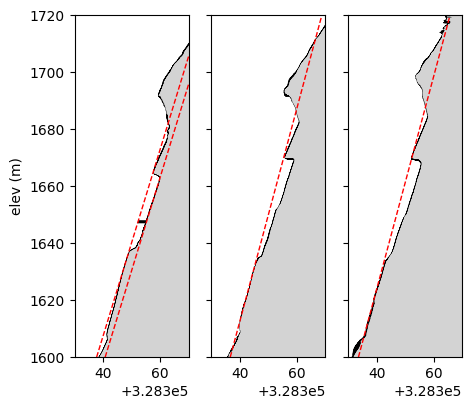

In [23]:
profiles = sorted(glob("Files/Cropped_Cable_Mtn_Profiles/Section cloud #*.txt"))

fig,ax = plt.subplots(1,3,figsize=(5,6),sharex=True,sharey=True)
prf1 = pd.read_csv(profiles[0],sep="\s+",header=None)
prf2 = pd.read_csv(profiles[1],sep="\s+",header=None)
prf3 = pd.read_csv(profiles[2],sep="\s+",header=None)

prf1 = prf1.sort_values(2).reset_index(drop=True)
prf2 = prf2.sort_values(2).reset_index(drop=True)
prf3 = prf3.sort_values(2).reset_index(drop=True)

# Draw the cross-section profiles
ax[0].fill_between(prf1[0],prf1[2],prf1[2].min(),fc="lightgray",ec="k",lw=0.1)
ax[1].fill_between(prf2[0],prf2[2],prf2[2].min(),fc="lightgray",ec="k",lw=0.1)
ax[2].fill_between(prf3[0],prf3[2],prf3[2].min(),fc="lightgray",ec="k",lw=0.1)

# Estimate the width and height of the blocks
ax[0].axline((328353, 1650),slope=dip_to_slope(73.),c="r",ls="--",lw=1)
ax[0].axline((328356, 1650),slope=dip_to_slope(73.),c="r",ls="--",lw=1)
ax[1].axline((328350, 1650),slope=dip_to_slope(75.),c="r",ls="--",lw=1)
ax[2].axline((328347, 1650),slope=dip_to_slope(75.),c="r",ls="--",lw=1)

ax[0].set_xlim(328330,328370),ax[0].set_ylim(1600,1720),ax[0].set_ylabel("elev (m)")
# ax[0].set_xticks([328330,328350,328370])
ax[0].set_aspect("equal"),ax[1].set_aspect("equal"),ax[2].set_aspect("equal")

print(f"Block thickness: {round(np.cos(np.radians(73))*3,2)} m")
plt.savefig("Figures/Rockfall_profiles.png",dpi=200,bbox_inches="tight")
plt.show()

### Estimate Block dimensions

/var/folders/8_/3chn0d6s3hj2h7k0fsrgkzsh0000gn/T/ipykernel_38591/2695891872.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


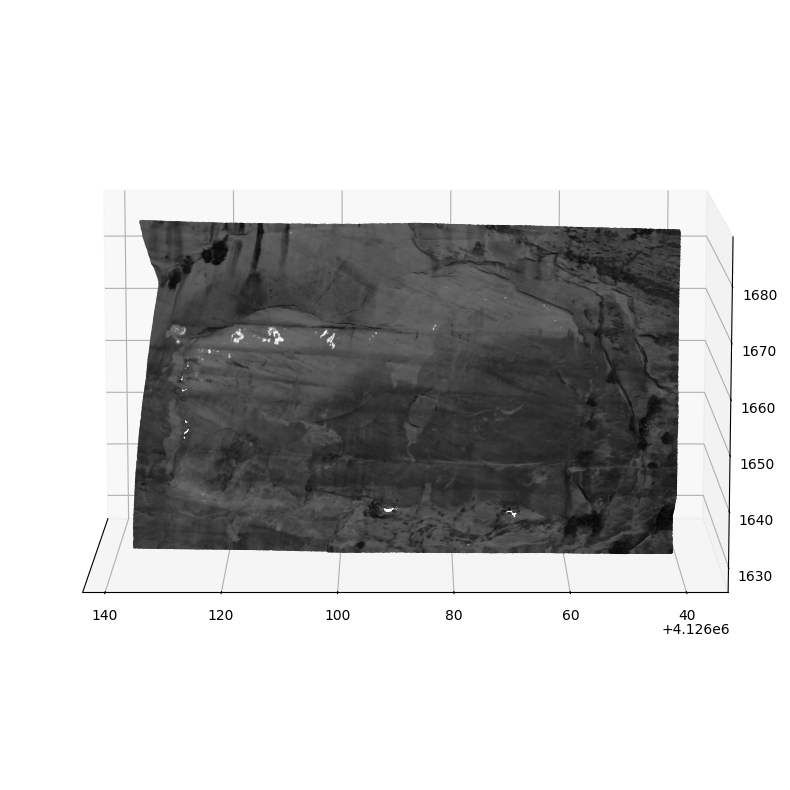

In [7]:
crp_bl = pd.read_csv("Files/Cropped_Cable_Mtn_Profiles/Rockfall_face.txt",sep="\s+",header=None)
blk_fc = crp_bl[[0,1,2]].to_numpy()
blk_rgb = crp_bl[[3,4,5]].to_numpy()
blk_bw = np.mean(blk_rgb,axis=1)
blk_bw = np.where(np.logical_and(blk_bw>0.84,blk_bw<0.9),blk_bw*2,blk_bw)
# np.where(<0.80,0.75*np.mean(blk_rgb,axis=1),2*np.mean(blk_rgb,axis=1))

fig = plt.figure(figsize=(8,8), constrained_layout=True)
ax = fig.add_subplot(projection='3d')
# ax.scatter(blk_fc[:,0],blk_fc[:,1],blk_fc[:,2],c=blk_rgb,s=1) # rgb
ax.scatter(blk_fc[:,0],blk_fc[:,1],blk_fc[:,2],c=blk_bw,s=1,cmap="gray")
ax.view_init(elev=10., azim=180)
ax.margins(z=0.01),ax.set_xticks([])
# Set box aspect ratio to be non-equal
ax.set_box_aspect([1, 1.8, 1])
plt.tight_layout()
plt.savefig("Figures/Rockfall_face_bw.png",dpi=200,bbox_inches="tight")
plt.show()

In [2]:
ptcl = laspy.read("Pointclouds/Cropped_CableMnt_RA_2019_PC_POI.las")
sam_pred = laspy.read("Pointclouds/SAM_Segments_Cropped_CableMnt_results.las") # sam_pred

### Define the color scheme
def norm_colors(x):
    "Convert 16-bit colors for plotting"
    nor = x/x.max()
    return nor

def norm_sam_colors(x,mult=1):
    "Convert 16-bit colors for plotting"
    nor = np.clip((x*mult)/255, 0, 1)
    return nor

r1 = norm_colors(ptcl.red)
g1 = norm_colors(ptcl.green)
b1 = norm_colors(ptcl.blue)

r = norm_sam_colors(sam_pred.red)
g = norm_sam_colors(sam_pred.green)
b = norm_sam_colors(sam_pred.blue)

rgb = np.stack([r1,g1,b1],axis=1)
pnts = np.stack([ptcl.x,ptcl.y,ptcl.z],axis=1)
# filt = np.where(np.logical_and(pnts[:,0]>-8e4,pnts[:,0]<5e4))[0]
# pnts = pnts[filt]
# rgb = rgb[filt]

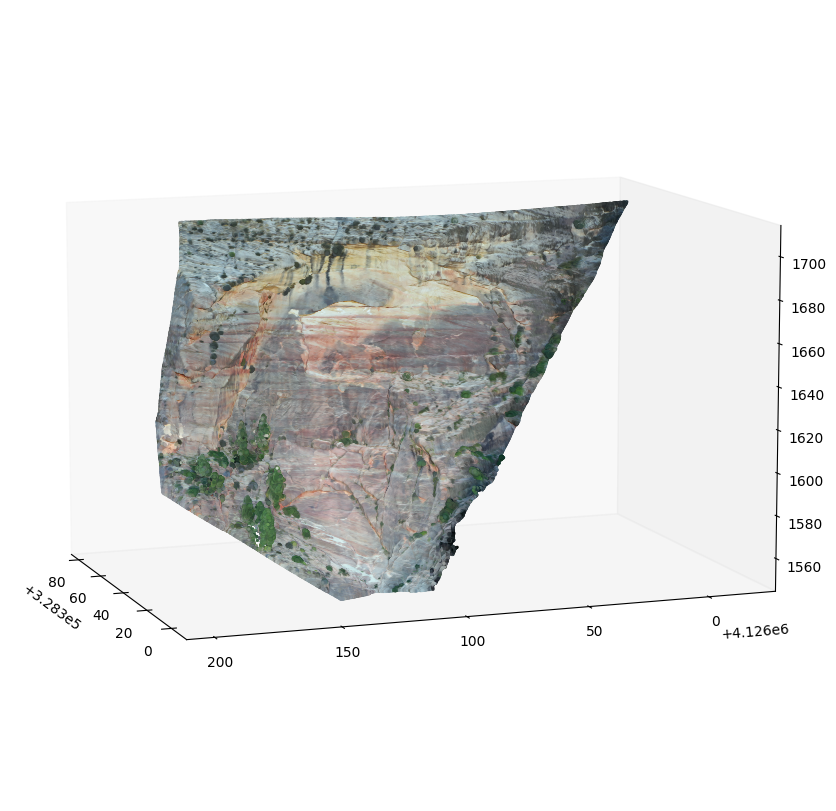

In [32]:
fig = plt.figure(figsize=(8,8), constrained_layout=True)
dcm = 2
ax = fig.add_subplot(projection='3d')

sc = ax.scatter(pnts[::dcm,0],pnts[::dcm,1],pnts[::dcm,2],c=rgb[::dcm],s=1,alpha=0.5)

ax.view_init(elev=10., azim=160)
ax.margins(z=0.01)
# ax.set_xlim(-8e4,5e4)
# Set box aspect ratio to be non-equal
ax.set_box_aspect([1, 1.5, 0.9])
ax.grid(False)
# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.show()

### Interpolate  the predicted mask from SAM to minimize black colors

In [17]:
x = ptcl.X
y = ptcl.Y
z = ptcl.z

# Define a threshold to identify black points
black_threshold = 0.1  # Adjust as needed

# Identify black points
black_points_indices = np.where((r < black_threshold) & (g < black_threshold) & (b < black_threshold))[0]
non_black_points_indices = np.where((r >= black_threshold) | (g >= black_threshold) | (b >= black_threshold))[0]

# Create a KDTree for fast nearest neighbor search
xyz_black = np.column_stack((x[black_points_indices], y[black_points_indices], z[black_points_indices]))
xyz_non_black = np.column_stack((x[non_black_points_indices], y[non_black_points_indices], z[non_black_points_indices]))
tree = cKDTree(xyz_non_black)

# Find nearest non-black neighbors for each black point and interpolate colors
interpolated_colors = []
for xyz in xyz_black:
    # Find the nearest neighbor and its index
    dist, index = tree.query(xyz)
    nearest_color = (r[non_black_points_indices[index]], g[non_black_points_indices[index]], b[non_black_points_indices[index]])
    interpolated_colors.append(nearest_color)

# Update the colors of the black points with the interpolated colors
r[black_points_indices], g[black_points_indices], b[black_points_indices] = np.array(interpolated_colors).T



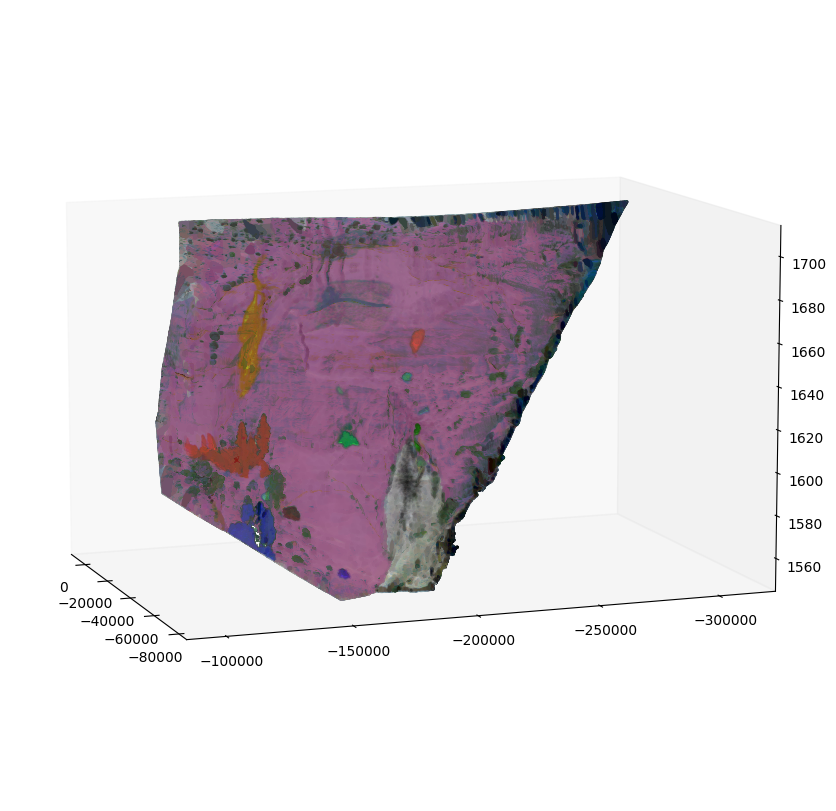

In [33]:
# Create scatter plot with interpolated colors
dcm = 1

fig = plt.figure(figsize=(8,8), constrained_layout=True)
ax = fig.add_subplot(projection='3d')
ax.scatter(x[::dcm], y[::dcm], z[::dcm], c=np.column_stack((r1[::dcm], g1[::dcm], b1[::dcm])), s=1)
ax.scatter(x[::dcm], y[::dcm], z[::dcm], c=np.column_stack((r[::dcm], g[::dcm], b[::dcm])), s=1, alpha=0.01)
ax.view_init(elev=10., azim=160)
ax.margins(z=0.01)
ax.set_box_aspect([1, 1.5, 0.9])
ax.grid(False)
plt.show()